<a href="https://colab.research.google.com/github/arokem/IntroDL/blob/master/CMI_T1w_GM_WM_CSFmasks_age_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saige Rutherford 

>Research Computer Specialist

>Department of Psychiatry, University of Michigan

[Website](https://www.beingsaige.com)
[Twitter](https://www.twitter.com/being_saige)
[GitHub](https://github.com/saigerutherford)

Data engineering scripts used to prepare this data can be accessed here: 

[Data Prep Scripts](https://github.com/saigerutherford/anatomically_defined_CNNs)

In [0]:
!wget -nc https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/requirements.txt

--2019-06-07 12:05:35--  https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1317 (1.3K) [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]   1.29K  --.-KB/s    in 0s      

2019-06-07 12:05:35 (223 MB/s) - ‘requirements.txt’ saved [1317/1317]



In [0]:
!pip install -r requirements.txt

     |████████████████████████████████| 2.2MB 7.7MB/s 
     |████████████████████████████████| 2.8MB 41.5MB/s 
     |████████████████████████████████| 890kB 48.8MB/s 
     |████████████████████████████████| 122kB 49.8MB/s 
     |████████████████████████████████| 778kB 44.3MB/s 
     |████████████████████████████████| 61kB 28.5MB/s 
     |████████████████████████████████| 14.8MB 32.1MB/s 
     |████████████████████████████████| 51kB 25.3MB/s 
     |████████████████████████████████| 3.3MB 32.5MB/s 
     |████████████████████████████████| 2.4MB 30.1MB/s 
     |████████████████████████████████| 9.0MB 32.9MB/s 
     |████████████████████████████████| 337kB 46.4MB/s 
     |████████████████████████████████| 1.2MB 41.1MB/s 
     |████████████████████████████████| 890kB 42.0MB/s 
     |████████████████████████████████| 235kB 54.1MB/s 
     |████████████████████████████████| 512kB 52.8MB/s 
     |████████████████████████████████| 276kB 41.2MB/s 
     |████████████████████████████████| 1.1MB 43.6

---
## Step 0: Load & Setup The Data

In [0]:
# general python packages
from __future__ import print_function
import os 
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt

# Deep Learning packages
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D, AveragePooling3D, Input, ZeroPadding3D
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, Adadelta, RMSprop, Adamax, Nadam, SGD # using Adam in this model, but just showing the other options here for future reference
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
# neuroimaging-specific python packages
import nilearn
from nilearn import plotting
import nibabel as nib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
!wget -nc https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/data/pheno_file.csv

--2019-06-07 12:07:58--  https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/data/pheno_file.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51946 (51K) [text/plain]
Saving to: ‘pheno_file.csv’

pheno_file.csv      100%[===================>]  50.73K  --.-KB/s    in 0.01s   

2019-06-07 12:07:58 (3.32 MB/s) - ‘pheno_file.csv’ saved [51946/51946]



In [0]:
# Read in csv file with subject info
pheno = pd.read_csv('pheno_file.csv')

In [0]:
pheno['Age'].describe()

count    906.000000
mean      10.824074
std        3.558937
min        5.036048
25%        8.039898
50%       10.031599
75%       13.057266
max       21.816563
Name: Age, dtype: float64

In [0]:
%matplotlib inline

<function matplotlib.pyplot.show>

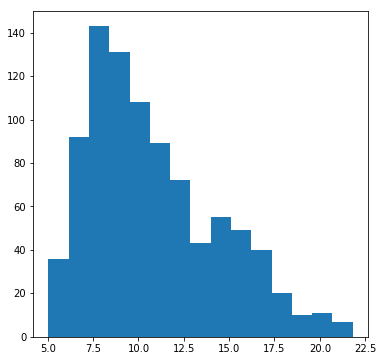

In [0]:
plt.figure(figsize=(6,6))
plt.hist(pheno['Age'],bins=15)
plt.show

In [0]:
!wget -nc https://storage.googleapis.com/ohbm-dl-lindsay-data/OHBM_DL_SR_data.zip

--2019-06-07 12:08:07--  https://storage.googleapis.com/ohbm-dl-lindsay-data/OHBM_DL_SR_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 265718959 (253M) [application/zip]
Saving to: ‘OHBM_DL_SR_data.zip’

OHBM_DL_SR_data.zip 100%[===================>] 253.41M   174MB/s    in 1.5s    

2019-06-07 12:08:09 (174 MB/s) - ‘OHBM_DL_SR_data.zip’ saved [265718959/265718959]



In [0]:
!unzip -uo OHBM_DL_SR_data.zip

Archive:  OHBM_DL_SR_data.zip
  inflating: OHBM_DL_data/downsampled_test_labels.npy  
  inflating: OHBM_DL_data/savedmodels/metadata_batch20_epoch10.tsv  
  inflating: OHBM_DL_data/downsampled_train_labels.npy  
  inflating: OHBM_DL_data/savedmodels/best_weights_batch5epoch30.h5  
  inflating: OHBM_DL_data/savedmodels/log_batch20epoch10.csv  
  inflating: OHBM_DL_data/savedmodels/weights.20-12.44.hdf5  
  inflating: OHBM_DL_data/savedmodels/best_weights_batch20epoch10.h5  
  inflating: OHBM_DL_data/savedmodels/metadata_batch5_epoch30.tsv  
  inflating: OHBM_DL_data/savedmodels/metadata_batch10_epoch20.tsv  
  inflating: OHBM_DL_data/savedmodels/log_batch10epoch20.csv  
  inflating: OHBM_DL_data/savedmodels/SavedModel_batch20_epoch10.h5  
  inflating: OHBM_DL_data/savedmodels/SavedModel_batch10_epoch20.h5  
  inflating: OHBM_DL_data/savedmodels/SavedModel_batch5_epoch30.h5  
  inflating: OHBM_DL_data/savedmodels/TensorBoardLogs/events.out.tfevents.1559899998.freewill  
  inflating: OHBM

In [0]:
root_path = 'OHBM_DL_data/'

In [0]:
ls OHBM_DL_data

downsampled_test_labels.npy  downsampled_train_labels.npy  savedmodels/
downsampled_test.npy         downsampled_train.npy


# Load data (already divided into train/test sets)

In [0]:
X_train = np.load(root_path + 'downsampled_train.npy')

In [0]:
X_test = np.load(root_path + 'downsampled_test.npy')

In [0]:
y_train = np.load(root_path + 'downsampled_train_labels.npy')

In [0]:
y_test = np.load(root_path + 'downsampled_test_labels.npy')

# Check input shape
### X_train.shape[0] = batch size (number of subjects in training)
### X_train.shape[1] = rows (x)
### X_train.shape[2] = columns (y)
### X_train.shape[3] = depth (z)
### X_train.shape[4] = channels (number of segmentations)

In [0]:
X_train.shape

(724, 48, 60, 46, 3)

In [0]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape

In [0]:
print("Number of training examples =", n_train)
print ("Number of test examples", n_test)
print("Image data shape =", image_shape)

Number of training examples = 724
Number of test examples 182
Image data shape = (48, 60, 46, 3)


# Step 1: Model Construction

In [0]:
model = Sequential() # The simplest model, a linear stack of layers

model.add(Conv3D(filters=64,
                 kernel_size=(3,3,3), #determines the width, height, depth of the 3D convolution window
                 activation='elu', #Exponential Linear Unit
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform', 
                 input_shape=image_shape)) # only the first layer needs to be told this info
model.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2))) # pooling is also referred to as a downsampling layer
model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch (aka make the mean activation close to 0 and the activation standard deviation close to 1)

model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters=16, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=16, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters=8, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=8, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2)))
model.add(BatchNormalization())

model.add(AveragePooling3D((2,2,2),strides=(2,2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='features')) #convert the output of the convolutional part of the CNN into a 1D feature vector. Length of vector = n_classes
model.add(Dense(1)) # final output is a single number (Age in this model)
model.summary()

filename="best_weights.h5"
filename2="weights.{epoch:02d}-{val_loss:.2f}.hdf5"


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 48, 60, 46, 64)    5248      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 24, 30, 23, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 30, 23, 64)    256       
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 24, 30, 23, 32)    55328     
_________________________________________________________________
conv

In [0]:
checkpoints = []

if not os.path.exists('Results01/'):
    os.makedirs('Results01/')

checkpoints.append(ModelCheckpoint('Results01/'+filename, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True, 
                                   save_weights_only=True, 
                                   mode='auto', 
                                   period=1))

checkpoints.append(ModelCheckpoint('Results01/'+filename2, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=False, 
                                   save_weights_only=True, 
                                   mode='auto', 
                                   period=20))

checkpoints.append(TensorBoard(log_dir='Results01/TensorBoardLogs', 
                               histogram_freq=0, 
                               write_graph=True, 
                               write_images=False, 
                               embeddings_freq=0, 
                               embeddings_layer_names=['features'], 
                               embeddings_metadata='metadata.tsv'))
#Early Stopping here is set so that if the MSE in the validation set does not improve after 10 epochs, training will stop
checkpoints.append(EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10))
checkpoints.append(ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0))
checkpoints.append(CSVLogger('Results01/log.csv'))

In [0]:
model.compile(loss='mse', # the objective that the model will try to minimize, Mean Square Error in this moel
              optimizer='adam', 
              metrics=['mae']) # add in any other metrics you want to use to show performance of the model, add accuracy here if you're doing classification

# Step 2: Model Training

In [0]:
# Check available GPUs
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
NUM_EPOCHS = 10 # defines for how many times the training will repeat. 1 epoch is 1 forward pass and 1 backward pass over all the training examples
BATCH_SIZE= 20 # the number of training examples in one forward/backward pass (or for 1 epoch)
history1= model.fit(X_train, y_train, 
          validation_split = 0.1, # This sets how much of the training data should be used as the validation set (test set during training)
          batch_size = BATCH_SIZE, 
          epochs = NUM_EPOCHS,
          callbacks = checkpoints)

Instructions for updating:
Use tf.cast instead.
Train on 651 samples, validate on 73 samples
Epoch 1/10
651/651 [==============================] - 59s 90ms/step - loss: 57.7585 - mean_absolute_error: 6.2414 - val_loss: 12.6858 - val_mean_absolute_error: 3.0295

Epoch 00001: val_loss improved from inf to 12.68576, saving model to Results01/best_weights.h5
Epoch 2/10
651/651 [==============================] - 47s 73ms/step - loss: 13.4328 - mean_absolute_error: 3.0389 - val_loss: 47.6312 - val_mean_absolute_error: 6.0403

Epoch 00002: val_loss did not improve from 12.68576
Epoch 3/10
651/651 [==============================] - 49s 76ms/step - loss: 13.0542 - mean_absolute_error: 2.9412 - val_loss: 111.2868 - val_mean_absolute_error: 9.8150

Epoch 00003: val_loss did not improve from 12.68576
Epoch 4/10
651/651 [==============================] - 50s 76ms/step - loss: 12.6467 - mean_absolute_error: 2.9328 - val_loss: 93.3161 - val_mean_absolute_error: 8.8069

Epoch 00004: val_loss did not i

# Step 3: Model Testing

In [0]:
model.evaluate(x=X_test, y=y_test)

182/182 [==============================] - 8s 45ms/step


[14.294641683389852, 2.837204506109049]

# Step 4: Save Model

**Saving/loading whole models (architecture + weights + optimizer state):**
1. the architecture of the model, allowing to re-create the model
2. the weights of the model
3. the training configuration (loss, optimizer)
4. the state of the optimizer, allowing to resume training exactly where you left off


In [0]:
model.save('Results01/SavedModel_Batch-20_Epochs-10.h5') #Always change this name when re-training (if you haven't changed directories) so you don't overwrite!

# Step 5: Load Pre-Trained Model, Compile, Evaluate

In [0]:
from keras.models import load_model

In [0]:
pretrain_model_b10e20 = load_model(root_path + 'savedmodels/SavedModel_batch10_epoch20.h5')

In [0]:
pretrain_model_b5e30 = load_model(root_path + 'savedmodels/SavedModel_batch5_epoch30.h5')

In [0]:
#pretrain_model_b10e20.summary()

In [0]:
#pretrain_model_b5e30.summary()

In [0]:
pretrain_model_b10e20.compile(loss='mse', # the objective that the model will try to minimize
              optimizer='adam', 
              metrics=['mae', 'acc']) # add in any other metrics you want to use to show performance of the model

In [0]:
pretrain_model_b5e30.compile(loss='mse', # the objective that the model will try to minimize
              optimizer='adam', 
              metrics=['mae', 'acc']) # add in any other metrics you want to use to show performance of the model

In [0]:
pretrain_model_b10e20.evaluate(x=X_test, y=y_test)

182/182 [==============================] - 4s 23ms/step


[12.952054757338304, 2.9791012019901486, 0.0]

In [0]:
pretrain_model_b5e30.evaluate(x=X_test, y=y_test)

182/182 [==============================] - 5s 25ms/step


[18.971883417485834, 3.136493648801531, 0.0]